### Lab 3: From binary classification to multiclass classification

In this demo, we cover binary classication through the OLS criterion. we consider both the K class discriminant as well as the one vs one and one vs rest classifiers. For each, we plot the decision bounndary using the meshgrid function from numpy. 

#### Part I. K class discriminant

The first and less ambiguous approach is to consider a single K classes discriminant. In this case, the first step is to encode the target using a binary representation $t = [0,1,0\ldots, 0]$ with $t^{(i)}_k = 1$ if $x^{(i)}$ is in class $k$. We can then solve the normal equations.

In [2]:
from sklearn.datasets import make_blobs
import numpy as np


X, y = make_blobs(n_samples=30, centers=3, n_features=2)

import matplotlib.pyplot as plt


#plt.scatter(X[:,0], X[:,1], c=)
print(y)

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(y.reshape(-1,1))
T = enc.transform(y.reshape(-1,1)).toarray()
T = np.array(T)

[0 2 1 2 0 0 1 2 1 2 0 2 0 1 0 1 2 1 0 2 0 1 1 2 1 2 0 0 1 2]


In [3]:
np.shape(np.array(T))

(30, 3)

In [4]:
import numpy as np
from numpy.linalg import inv

Xtilde = np.hstack((np.ones((np.shape(X)[0],1)), X))

XX = np.matmul(Xtilde.T, Xtilde)
XT = np.matmul(Xtilde.T, T)

Beta = np.matmul(inv(XX), XT)
print(Beta)

[[ 0.30111694  1.00905125 -0.3101682 ]
 [ 0.06256932 -0.17844449  0.11587516]
 [ 0.15731053 -0.01088175 -0.14642878]]


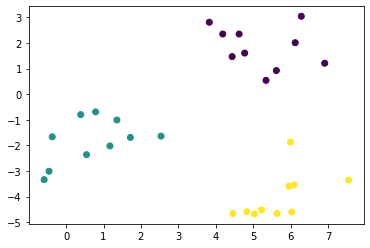

In [5]:
plt.scatter(X[:,0], X[:,1], c = y)
plt.show()

(3, 10000)


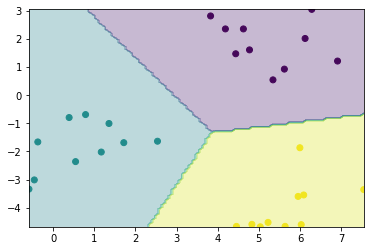

In [6]:
import numpy as np

x1min = np.min(X[:,0])
x1max = np.max(X[:,0])
x2min = np.min(X[:,1])
x2max = np.max(X[:,1])

xx1, xx2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))

Xpredict = np.vstack((xx1.flatten(), xx2.flatten())).T

XtildePredict = np.hstack((np.ones((np.shape(Xpredict)[0],1)), Xpredict))

prediction = np.matmul(Beta.T,XtildePredict.T) 
print(np.shape(prediction))

predictedTargets = np.zeros((len(xx1.flatten()), 1))

for i in range(len(xx1.flatten())):
    
    predictedTargets[i] = np.argmax(prediction[:,i])
    

    
    
plt.scatter(X[:,0], X[:,1], c = y)
plt.contourf(xx1, xx2, np.reshape(predictedTargets,np.shape(xx1)), alpha = .3)
plt.show()

#### Part II: One vs One

In this case, we need to learn K(K-1)/2 = 3 classifiers. The classification is then made through a majority vote. Some ambiguity might remain when the maximum number of votes is shared equally among multiple classes. 

In [7]:
# one vs one 

num_classes = max(y)+1


from __future__ import division



num_classifiers = int(num_classes*(num_classes-1)/2)

## generating the grid for the final display
x1min = np.min(X[:,0])
x1max = np.max(X[:,0])
x2min = np.min(X[:,1])
x2max = np.max(X[:,1])

xx1, xx2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))

Xpredict = np.vstack((xx1.flatten(), xx2.flatten())).T
Xtilde_predict = np.hstack((np.ones((np.shape(Xpredict)[0],1)), Xpredict))


PredictionMatrix = np.zeros((len(xx1.flatten()),num_classifiers))

counter = 0

for i in range(num_classes):

    for j in range(num_classes):

        if j> i:

            print('('+str(i)+str(j)+')')

            indices_i = np.squeeze(np.where(y==i))
            indices_j = np.squeeze(np.where(y==j))

            points_classi = Xtilde[indices_i,:]
            points_classj = Xtilde[indices_j,:]


            Xtilde_ij = np.vstack((points_classi, points_classj))

            target_i = np.ones((len(indices_i),1))
            target_j = np.zeros((len(indices_j),1))



            target_ij = np.vstack((target_i, target_j))

            # learning the plane

            XX = np.matmul(Xtilde_ij.T, Xtilde_ij)
            XT = np.matmul(Xtilde_ij.T, target_ij)

            beta_ij = np.matmul(inv(XX), XT)

            prediction_ij = np.matmul(XtildePredict, beta_ij)

            target_final_ij = np.zeros((len(prediction_ij),1))
            Test_indices_i = np.squeeze(np.where(prediction_ij>0.5))  
            target_final_ij[Test_indices_i] = i
            Test_indices_j = np.squeeze(np.where(prediction_ij<=0.5))  
            target_final_ij[Test_indices_j] = j

            PredictionMatrix[:,counter] = np.squeeze(target_final_ij)

        
            counter +=1
        

(01)
(02)
(12)


In [37]:
print(PredictionMatrix)

[[1. 2. 2.]
 [1. 2. 1.]
 [1. 2. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


To get the final classification, we now use a majority vote. Relying on the classes stored in 'PredictionMatrix' we count the number of times each sample is classified in a particular class. we then associate the most represented class to each point. In the case of a draw we illustrate the result with a fourth class. 

In [42]:
final_class = np.zeros((np.shape(PredictionMatrix)[0],1))

for i in np.arange(np.shape(PredictionMatrix)[0]):

    count = np.zeros((3,1))
    for j in np.arange(3):
        tmp1 = np.where(PredictionMatrix[i,:]== j)
        numVotesForj = len(tmp1[0])
        count[j] = numVotesForj 
    
    maxVotes = np.max(count)
    tmp2 = np.where(count == maxVotes)
    Is_Vote_ambiguous = len(tmp2[0])>1
    
    if not Is_Vote_ambiguous:
        final_class[i] = np.argmax(count)
    else:
        final_class[i] = 3
        print('decision is ambiguous')

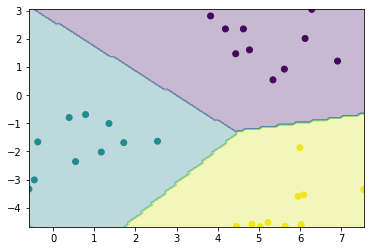

In [43]:
# displaying the result   

plt.scatter(X[:,0], X[:,1], c = y)
plt.contourf(xx1, xx2, np.reshape(final_class,np.shape(xx1)), alpha = .3)
plt.show()

#### Part III: One vs rest 

Here we need to compute N-1 classifier for each of the K-1 vs rest classes. The last (i.e. K) class is defined from the points that haven't been put in any of the K-1 previous classes. The only difference with the one vs one classifier lies in the relabelling of the samples at each step. 

In [63]:
# one vs one 

num_classes = max(y)+1


from __future__ import division



num_classifiers = int(num_classes*(num_classes-1)/2)

## generating the grid for the final display
x1min = np.min(X[:,0])
x1max = np.max(X[:,0])
x2min = np.min(X[:,1])
x2max = np.max(X[:,1])

xx1, xx2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))

Xpredict = np.vstack((xx1.flatten(), xx2.flatten())).T
Xtilde_predict = np.hstack((np.ones((np.shape(Xpredict)[0],1)), Xpredict))


prediction_final = 2*np.ones((len(xx1.flatten()),1))


indices_Allclasses = np.zeros((len(xx1.flatten()),num_classes-1))


counter = 0

for i in np.arange(num_classes-1):

    print('('+str(i)+')')

    indices_i = np.squeeze(np.where(y==i))

    indices = np.zeros((len(y),1))
    indices[indices_i] = 1
    
    points_classi = Xtilde[np.where(indices==1)[0],:]
    points_rest = Xtilde[np.where(indices==0)[0],:]

    Xtilde_total = np.vstack((points_classi, points_rest))

    target_i = np.ones((len(np.where(indices==1)[0]),1))
    target_rest = np.zeros((len(np.where(indices==0)[0]),1))

    target_total = np.vstack((target_i, target_rest))

    # learning the plane

    XX = np.matmul(Xtilde_total.T, Xtilde_total)
    XT = np.matmul(Xtilde_total.T, target_total)

    beta_i = np.matmul(inv(XX), XT)

    prediction_i = np.matmul(XtildePredict, beta_i)

    indices_classi = np.where(prediction_i>0.5)[0]
    
    # checking for possible ambiguity 
    
    indices_Allclasses[indices_classi,i] = 1

    
    prediction_final[indices_classi] = i


(0)
(1)


In [69]:
print(ambiguous_indices)

[6241 6339 6340 ... 9937 9938 9939]


In [72]:
# displaying ambiguous classifications

ambiguous_indices = np.where(np.sum(indices_Allclasses,axis=1)==2)[0]
prediction_final[ambiguous_indices]=-1

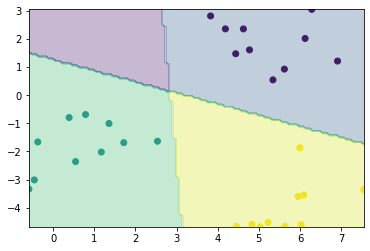

In [73]:
# displaying the result, and highlighting ambiguities  

plt.scatter(X[:,0], X[:,1], c = y)
plt.contourf(xx1, xx2, np.reshape(prediction_final,np.shape(xx1)), alpha = .3)
plt.show()